In [22]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data, generate_dataset_g
from nn_models import LeNet, aliG, denseG, aliGs
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
torch.__version__

'0.4.1'

In [3]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=False)
train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [4]:
len(train_input)

1000

5


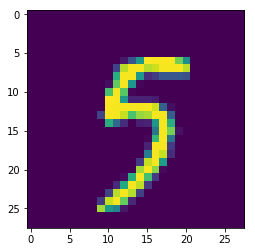

In [5]:
i = 420
plt.imshow(train_input[i, 0, :, :])
print(train_target[i].item())

## 1) LeNet F

In [6]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

in_channels = train_input.shape[1]
out_channels = 10

In [7]:
#debug_layers_dims(LeNet_gen(), train_input.shape)

In [8]:
target_classes = np.array(train_target.tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 97, 1: 116, 2: 99, 3: 93, 4: 105, 5: 92, 6: 94, 7: 117, 8: 87, 9: 100}


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.02215846           0.247      0.00211227           0.307
10                   0.00298656           0.921      0.00052257           0.844
20                   0.00118625           0.967      0.00027482           0.908
30                   0.00041886           0.996      0.00021881           0.917
39                   0.00020069           1.000      0.00019959           0.925
*******************************************************************************


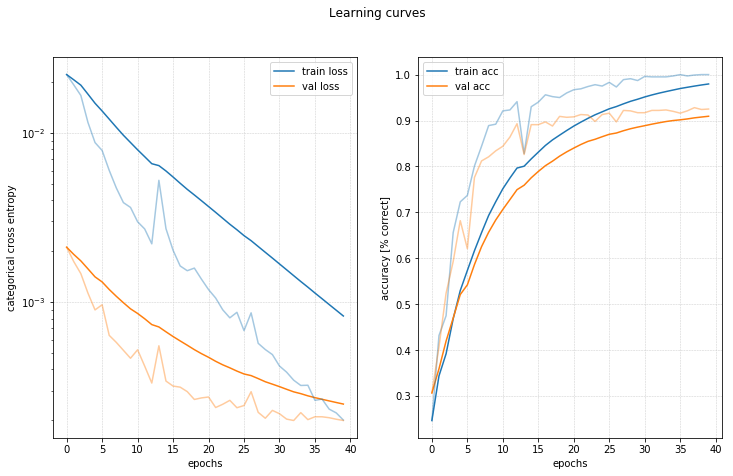

In [9]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

net = LeNet()
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.05

mt = ModelTrainer(net, loss_fun, optim.SGD(net.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=40, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

## 2) Net G

In [40]:
(g_train_input, g_train_target), (g_test_input, g_test_target) = \
generate_dataset_g(net, train_dataset, test_dataset, [net.conv2], ['conv 2'], split=0.5, full=False)

g_train_target = g_train_target.long()
g_test_target = g_test_target.long()

g_train_dataset = (g_train_input, g_train_target)
g_test_dataset = (g_test_input, g_test_target)  

In [41]:
g_train_target.shape

torch.Size([1000])

In [42]:
size_input_vector = g_train_dataset[0].shape[2]
print("size of layer vector :", size_input_vector)

size of layer vector : 1024


In [43]:
target_classes = np.array(g_train_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 500, 1: 500}


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00070897           0.504      0.22477069           0.500
10                   0.17474356           0.491      0.12189390           0.474
20                   0.06885330           0.587      0.05132386           0.611
30                   0.03331471           0.568      0.01349134           0.605
40                   0.01546597           0.565      0.00666659           0.594
50                   0.01073125           0.558      0.00303141           0.662
60                   0.00882519           0.569      0.00344216           0.681
70                   0.00651224           0.612      0.00210079           0.678
80                   0.00614421           0.578      0.00286911           0.670
90                   0.00521537           0.556      0.00260233           0.665
100                  0.00484982         

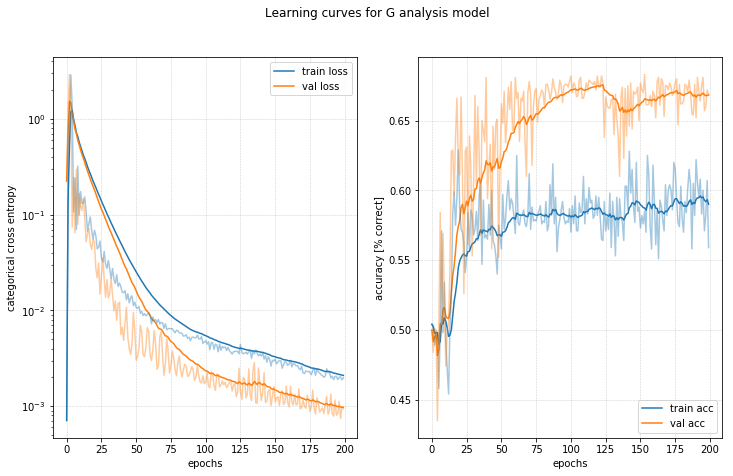

In [48]:
modelG = denseG(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.1

mt = ModelTrainer(modelG, loss_fun, optim.Adamax(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=200, batch_size=1000, verbose=10)
mt.plot_training("Learning curves for G analysis model")